In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22, lgdFrameAlpha=0.0,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':lgdFrameAlpha}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
color_gamma = 'tab:green'
color_CP0 = 'tab:red'
color_kbP = 'tab:orange'

# mean residence time phase diagram

In [4]:
def criticalRate_DNAclusTarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    KPSC0chiS = parm['KPS'].to_numpy()*0.6022*chiS
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    nu_add = onRate*KPSC0chiS*(1+chiN*gamma)**2
    return (nu+nu_add)/chiDNA**2

def criticalRate_DNAtarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_DNA(parm):
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return gamma*chiN*kbPN

In [67]:
parms = GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=np.logspace(0,3,100), 
    KPP=[1e3], kbPP_fixed=0.1,
)


[]

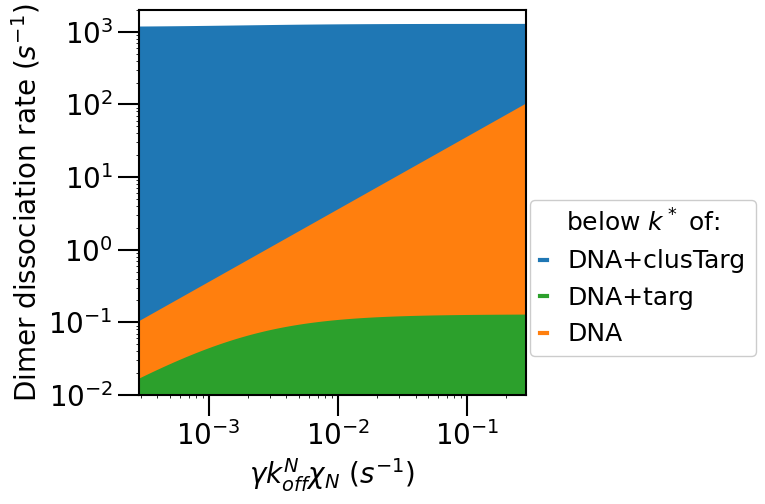

In [69]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[1.01,0.1], lgdFontSize=18, lgdHandleL=0.3, lgdFrameAlpha=1.0,
    lgdTitle='below $k^*$ of:', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)
plt.rcParams['lines.linewidth'] = 3
import matplotlib.patheffects as pe

ymin = 1e-2
gammaChiNkoff = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['kbPN'].to_numpy()

plt.plot(gammaChiNkoff, criticalRate_DNAclusTarg(parms), label='DNA+clusTarg', color='tab:blue')
plt.plot(gammaChiNkoff, criticalRate_DNAtarg(parms), label='DNA+targ', color='tab:green')
plt.plot(gammaChiNkoff, criticalRate_DNA(parms), label='DNA', color='tab:orange')

plt.fill_between(gammaChiNkoff, ymin, criticalRate_DNAclusTarg(parms), color='tab:blue')
plt.fill_between(gammaChiNkoff, ymin, criticalRate_DNA(parms), color='tab:orange')
plt.fill_between(gammaChiNkoff, ymin, criticalRate_DNAtarg(parms), color='tab:green')

plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.xlabel('$\gamma k_{off}^{N} \chi_N$ ($s^{-1}$)', **labelfont)
plt.ylabel('Dimer dissociation rate ($s^{-1}$)', **labelfont)

plt.xlim([min(gammaChiNkoff), max(gammaChiNkoff)])
plt.ylim([ymin, 2e3])

plt.legend(**legend)

plt.loglog()

# occupancy phase diagram